## 03_CNN.ipynb

In [3]:
import zipfile

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

## 데이터 분석을 하든 머신러닝을 하든 아주 중요한 첫 단계는 데이터와 하나가 되는 것,
## 즉, 데이터를 살펴보고 알아보는 것 => 시각화 이용할 수도 있고, 간단한 통계량을 활용 수도 있습니다.

In [4]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
    print(f"{dirpath}에는 {len(dirnames)}개의 디렉토리와 {len(filenames)}개의 파일이 존재합니다.")

pizza_steak에는 2개의 디렉토리와 1개의 파일이 존재합니다.
pizza_steak\test에는 2개의 디렉토리와 1개의 파일이 존재합니다.
pizza_steak\test\pizza에는 0개의 디렉토리와 250개의 파일이 존재합니다.
pizza_steak\test\steak에는 0개의 디렉토리와 250개의 파일이 존재합니다.
pizza_steak\train에는 2개의 디렉토리와 1개의 파일이 존재합니다.
pizza_steak\train\pizza에는 0개의 디렉토리와 750개의 파일이 존재합니다.
pizza_steak\train\steak에는 0개의 디렉토리와 750개의 파일이 존재합니다.


In [5]:
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

In [8]:
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/")
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['pizza' 'steak']


## pizza 및 steak는 모두 750장의 학습 데이터와 250장의 테스트 데이터가 존재합니다.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)

    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")

    return img

Image shape: (512, 384, 3)


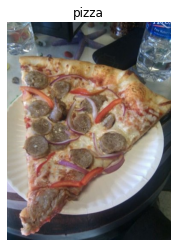

In [35]:
img = view_random_image(target_dir = "pizza_steak/train/", target_class = "pizza")

In [36]:
img

array([[[134, 128, 132],
        [147, 141, 145],
        [157, 152, 156],
        ...,
        [ 62,  82, 141],
        [153, 172, 228],
        [108, 128, 181]],

       [[149, 144, 148],
        [159, 154, 158],
        [165, 160, 164],
        ...,
        [125, 146, 203],
        [150, 170, 223],
        [ 56,  76, 126]],

       [[145, 143, 146],
        [149, 149, 151],
        [152, 152, 154],
        ...,
        [158, 180, 230],
        [109, 131, 178],
        [ 15,  38,  80]],

       ...,

       [[ 20,  35,  54],
        [ 19,  34,  53],
        [ 18,  33,  52],
        ...,
        [ 17,  21,  22],
        [ 17,  21,  22],
        [ 15,  19,  20]],

       [[ 21,  36,  57],
        [ 20,  35,  56],
        [ 18,  33,  54],
        ...,
        [ 19,  23,  24],
        [ 18,  22,  23],
        [ 16,  20,  21]],

       [[ 23,  38,  59],
        [ 22,  37,  58],
        [ 21,  36,  57],
        ...,
        [ 20,  24,  25],
        [ 19,  23,  24],
        [ 18,  22,  23]]

In [37]:
img.shape # return의 형태는 (width, height, color channel = RGB)

(512, 384, 3)

In [38]:
img / 255.  # 값을 0 ~ 1사이로 scaling => normalization
# 왜 255.로 나누느냐? RGB는 0 ~ 255의 값을 가진다.

array([[[0.5254902 , 0.50196078, 0.51764706],
        [0.57647059, 0.55294118, 0.56862745],
        [0.61568627, 0.59607843, 0.61176471],
        ...,
        [0.24313725, 0.32156863, 0.55294118],
        [0.6       , 0.6745098 , 0.89411765],
        [0.42352941, 0.50196078, 0.70980392]],

       [[0.58431373, 0.56470588, 0.58039216],
        [0.62352941, 0.60392157, 0.61960784],
        [0.64705882, 0.62745098, 0.64313725],
        ...,
        [0.49019608, 0.57254902, 0.79607843],
        [0.58823529, 0.66666667, 0.8745098 ],
        [0.21960784, 0.29803922, 0.49411765]],

       [[0.56862745, 0.56078431, 0.57254902],
        [0.58431373, 0.58431373, 0.59215686],
        [0.59607843, 0.59607843, 0.60392157],
        ...,
        [0.61960784, 0.70588235, 0.90196078],
        [0.42745098, 0.51372549, 0.69803922],
        [0.05882353, 0.14901961, 0.31372549]],

       ...,

       [[0.07843137, 0.1372549 , 0.21176471],
        [0.0745098 , 0.13333333, 0.20784314],
        [0.07058824, 0

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagenerator = ImageDataGenerator(rescale = 1./255)
valid_datagenerator = ImageDataGenerator(rescale = 1./255)

train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

train_data = train_datagenerator.flow_from_directory(
    train_dir,
    batch_size = 32,   # 1번에 처리할 이미지의 갯수를 지정
    target_size = (224, 224), # 이미지의 크기를 224, 244로 조정 (resize)
    class_mode = "binary", # 우리가 처리할 방법
    seed = 42
)

valid_data = valid_datagenerator.flow_from_directory(
    test_dir,
    batch_size = 32,   # 1번에 처리할 이미지의 갯수를 지정
    target_size = (224, 224), # 이미지의 크기를 224, 244로 조정 (resize)
    class_mode = "binary", # 우리가 처리할 방법
    seed = 42
)

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters = 10,
        kernel_size = 3,  # (3, 3)
        activation = "relu",
        input_shape = (224, 224, 3)
    ),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(
        pool_size = 2, # (2, 2)
        padding = "valid"
    ),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_1.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_1 = model_1.fit(
    train_data,
    epochs = 5,
    validation_data = valid_data
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 30s 637ms/step - loss: 0.5487 - accuracy: 0.7133 - val_loss: 0.4267 - val_accuracy: 0.7860
Epoch 2/5
47/47 [==============================] - 31s 650ms/step - loss: 0.4342 - accuracy: 0.7993 - val_loss: 0.3419 - val_accuracy: 0.8600
Epoch 3/5
47/47 [==============================] - 31s 666ms/step - loss: 0.4020 - accuracy: 0.8253 - val_loss: 0.3799 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 31s 652ms/step - loss: 0.3698 - accuracy: 0.8460 - val_loss: 0.3003 - val_accuracy: 0.8700
Epoch 5/5
47/47 [==============================] - 30s 640ms/step - loss: 0.3663 - accuracy: 0.8440 - val_loss: 0.3251 - val_accuracy: 0.8820


In [40]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

In [41]:
tf.random.set_seed(42)

# 1. 모델을 create
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# 2. 모델을 compile
model_2.compile(
    loss = "binary_crossentropy",  
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# 3. 모델을 fit
history_2 = model_2.fit(
    train_data, 
    epochs = 5,
    validation_data = valid_data,
)

Epoch 1/5
47/47 [==============================] - 5s 100ms/step - loss: 0.8702 - accuracy: 0.5053 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 5s 97ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 5s 97ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 4s 93ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 4s 95ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


In [42]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


## summary에서 parameter들은 데이터에서 모델이 학습할 수 있는 패턴들로 간주할 수 있다.
## 직관적으로 생각한다면 parameter 갯수가 많으면 많을 수록 더 좋지 않을까 합니다.
## model_2에서는 dense 층을 많이 사용했고, 이 층을 이루는 parameter들은 서로 연결되어 있고,
## 학습해야 할 패턴들이 많아진다.
## model_1에서 사용한 CNN (convolutional nerual network)는 이미지에서 가장 중요한 패턴을 찾으려고 노력합니다.
## 그래서 parameter가 갯수가 적더라도, 이미지에서 서로다른 feature (특징)들을 구분하는데 도움이 됩니다.

In [43]:
# 성능을 높이기 위해서 layer를 추가하고, 각 레이어의 뉴런을 늘려본다.

tf.random.set_seed(42)

# 1. 모델을 create
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),    
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# 2. 모델을 compile
model_3.compile(
    loss = "binary_crossentropy",  
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# 3. 모델을 fit
history_3 = model_3.fit(
    train_data, 
    epochs = 5,
    validation_data = valid_data,
)

Epoch 1/5
47/47 [==============================] - 6s 115ms/step - loss: 3.6727 - accuracy: 0.6280 - val_loss: 1.0766 - val_accuracy: 0.7040
Epoch 2/5
47/47 [==============================] - 5s 115ms/step - loss: 0.7757 - accuracy: 0.7307 - val_loss: 0.6584 - val_accuracy: 0.7420
Epoch 3/5
47/47 [==============================] - 5s 112ms/step - loss: 0.9802 - accuracy: 0.6973 - val_loss: 0.6316 - val_accuracy: 0.7440
Epoch 4/5
47/47 [==============================] - 5s 113ms/step - loss: 0.5406 - accuracy: 0.7793 - val_loss: 0.5961 - val_accuracy: 0.7180
Epoch 5/5
47/47 [==============================] - 5s 113ms/step - loss: 0.5197 - accuracy: 0.7633 - val_loss: 0.8280 - val_accuracy: 0.6920


In [44]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


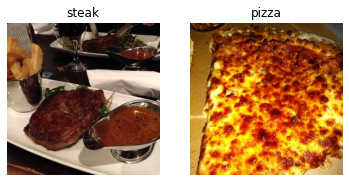

In [48]:
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
steak_img = view_random_image("pizza_steak/train/", "pizza")

In [49]:
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagenerator = ImageDataGenerator(rescale=1/255.)
test_datagenerator = ImageDataGenerator(rescale=1/255.)

In [58]:
train_data = train_datagenerator.flow_from_directory(
    directory = train_dir,
    target_size = (224, 224),
    class_mode = "binary",
    batch_size = 32
)

test_data = test_datagenerator.flow_from_directory(
    directory = test_dir,
    target_size = (224, 224),
    class_mode = "binary",
    batch_size = 32
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [59]:
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

In [60]:
images[:2], images[0].shape

(array([[[[0.7019608 , 0.7294118 , 0.7686275 ],
          [0.7019608 , 0.7294118 , 0.7686275 ],
          [0.7137255 , 0.7411765 , 0.7803922 ],
          ...,
          [0.7960785 , 0.627451  , 0.49411768],
          [0.68235296, 0.5058824 , 0.37647063],
          [0.76470596, 0.5803922 , 0.46274513]],
 
         [[0.7019608 , 0.7294118 , 0.7607844 ],
          [0.7176471 , 0.74509805, 0.77647066],
          [0.7137255 , 0.7411765 , 0.7725491 ],
          ...,
          [0.7176471 , 0.54509807, 0.3921569 ],
          [0.7019608 , 0.5254902 , 0.37254903],
          [0.7058824 , 0.5176471 , 0.36078432]],
 
         [[0.654902  , 0.68235296, 0.7137255 ],
          [0.70980394, 0.7372549 , 0.7686275 ],
          [0.7058824 , 0.73333335, 0.76470596],
          ...,
          [0.7137255 , 0.5411765 , 0.35686275],
          [0.69411767, 0.5058824 , 0.31764707],
          [0.76470596, 0.5764706 , 0.38431376]],
 
         ...,
 
         [[0.37254903, 0.16470589, 0.10980393],
          [0.40784

In [61]:
labels

array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [62]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [63]:
model_4 = Sequential([
    Conv2D(
        filters = 10,
        kernel_size = 3,
        strides = 1,
        padding = "valid",
        activation = "relu",
        input_shape = (224, 224, 3)
    ),
    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    Flatten(),
    Dense(1, activation = "sigmoid")
])

In [64]:

model_4.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [65]:
len(train_data), len(test_data)

(47, 16)

In [66]:
history_4 = model_4.fit(
    train_data,
    epochs = 5,
    validation_data = test_data
)

Epoch 1/5
47/47 [==============================] - 33s 706ms/step - loss: 1.6739 - accuracy: 0.6227 - val_loss: 0.5143 - val_accuracy: 0.7420
Epoch 2/5
47/47 [==============================] - 37s 783ms/step - loss: 0.4341 - accuracy: 0.8140 - val_loss: 0.4133 - val_accuracy: 0.8220
Epoch 3/5
47/47 [==============================] - 39s 826ms/step - loss: 0.2820 - accuracy: 0.9053 - val_loss: 0.3949 - val_accuracy: 0.8280
Epoch 4/5
47/47 [==============================] - 35s 749ms/step - loss: 0.1385 - accuracy: 0.9547 - val_loss: 0.5300 - val_accuracy: 0.7680
Epoch 5/5
47/47 [==============================] - 37s 782ms/step - loss: 0.0760 - accuracy: 0.9833 - val_loss: 0.5397 - val_accuracy: 0.7620


<AxesSubplot:>

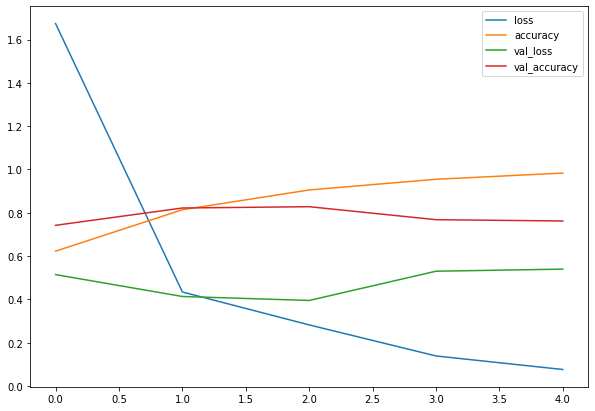

In [67]:
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize = (10, 7))

## overfitting이 된 상태!!!
## validation loss가 증가하기 시작하면, 학습 데이터를 overfitting이 되어가고 있다
## 즉, 너무나도 학습 데이터의 패턴을 잘 학습하기는 했다. 그런데 잘 모르는 데이터에 대해서 대응 잘 못한다.

In [73]:
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="traning_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="traning_accuracy")
    plt.plot(epochs, val_accuracy, label="val_val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()    


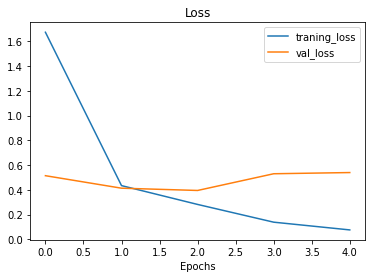

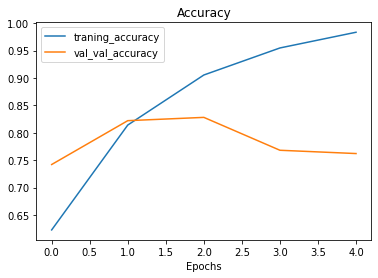

In [74]:
plot_loss_curves(history_4)

In [75]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [76]:
model_5 = Sequential([
    Conv2D(
        filters = 10,
        kernel_size = 3,
        strides = 1,
        padding = "valid",
        activation = "relu",
        input_shape = (224, 224, 3)
    ),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = "sigmoid")
])

In [77]:
model_5.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [78]:
history_5 = model_5.fit(
    train_data,
    epochs = 5,
    validation_data = test_data
)

Epoch 1/5
47/47 [==============================] - 14s 289ms/step - loss: 0.6277 - accuracy: 0.6613 - val_loss: 0.4649 - val_accuracy: 0.7980
Epoch 2/5
47/47 [==============================] - 14s 288ms/step - loss: 0.4739 - accuracy: 0.7753 - val_loss: 0.4512 - val_accuracy: 0.7920
Epoch 3/5
47/47 [==============================] - 14s 303ms/step - loss: 0.4476 - accuracy: 0.8060 - val_loss: 0.3907 - val_accuracy: 0.8500
Epoch 4/5
47/47 [==============================] - 15s 308ms/step - loss: 0.4048 - accuracy: 0.8280 - val_loss: 0.4129 - val_accuracy: 0.8180
Epoch 5/5
47/47 [==============================] - 15s 309ms/step - loss: 0.3934 - accuracy: 0.8320 - val_loss: 0.3643 - val_accuracy: 0.8380


In [79]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)             

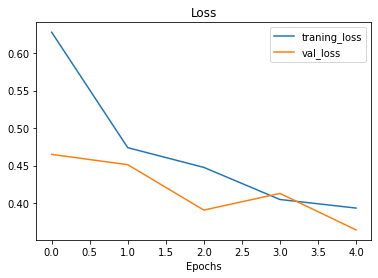

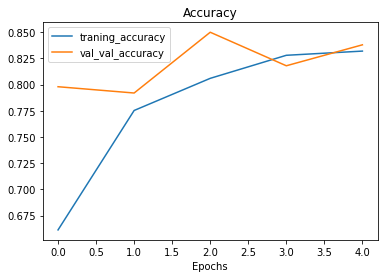

In [80]:
plot_loss_curves(history_5)

## Convolutional Neural Network의 특징 -> 가능한 이미지에서 중요한 특징, 즉 패턴을 찾겠다!!!
## MaxPooling2D의 특징 -> 가장 중요한 패턴 찾았어? 그럼 나는 쓸모없는 것 제거해 줄게!
## pool_size가 (2, 2) -> 2행 2열짜리 즉, 한번에 4개 데이터를 가지고 1개만 선택
## pool_size가 (5, 5) -> 5행 5열짜리 즉, 한번에 25개 데이터를 가지고 1개만 선택


## Data Augmentation : overfitting을 방지하는 기법
## 학습 데이터를 변형하는 과정 => 데이터의 다양성을 더 추가하여 더 많은 패턴을 익히도록 하는 것! 

In [82]:
train_datagenerator_augmented = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True
)
train_datagenerator = ImageDataGenerator(rescale = 1./255)
valid_datagenerator = ImageDataGenerator(rescale = 1./255)

In [89]:

train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

train_data_augmented = train_datagenerator_augmented.flow_from_directory(
    train_dir,
    batch_size = 32,   # 1번에 처리할 이미지의 갯수를 지정
    target_size = (224, 224), # 이미지의 크기를 224, 244로 조정 (resize)
    class_mode = "binary", # 우리가 처리할 방법
    shuffle = False
)

train_data = train_datagenerator.flow_from_directory(
    train_dir,
    batch_size = 32,   # 1번에 처리할 이미지의 갯수를 지정
    target_size = (224, 224), # 이미지의 크기를 224, 244로 조정 (resize)
    class_mode = "binary", # 우리가 처리할 방법
    shuffle = False
)

valid_data = valid_datagenerator.flow_from_directory(
    test_dir,
    batch_size = 32,   # 1번에 처리할 이미지의 갯수를 지정
    target_size = (224, 224), # 이미지의 크기를 224, 244로 조정 (resize)
    class_mode = "binary", # 우리가 처리할 방법
)

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [90]:
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next()

(-0.5, 223.5, 223.5, -0.5)

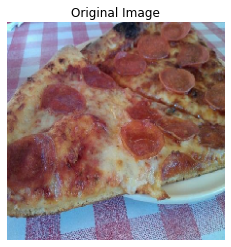

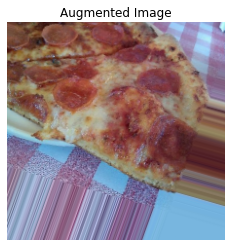

In [99]:
random_number = random.randint(0, 32)
plt.imshow(images[random_number])
plt.title("Original Image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title("Augmented Image")
plt.axis(False)

In [100]:
model_6 = Sequential([
    Conv2D(
        filters = 10,
        kernel_size = 3,
        strides = 1,
        padding = "valid",
        activation = "relu",
        input_shape = (224, 224, 3)
    ),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = "sigmoid")
])

model_6.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_6 = model_6.fit(
    train_data_augmented,
    epochs = 5,
    validation_data = valid_data
)

Epoch 1/5
47/47 [==============================] - 22s 466ms/step - loss: 0.7120 - accuracy: 0.4593 - val_loss: 0.6852 - val_accuracy: 0.5060
Epoch 2/5
47/47 [==============================] - 22s 459ms/step - loss: 0.6944 - accuracy: 0.5560 - val_loss: 0.6727 - val_accuracy: 0.5640
Epoch 3/5
47/47 [==============================] - 22s 476ms/step - loss: 0.6942 - accuracy: 0.5440 - val_loss: 0.6336 - val_accuracy: 0.7220
Epoch 4/5
47/47 [==============================] - 23s 488ms/step - loss: 0.6792 - accuracy: 0.6233 - val_loss: 0.6312 - val_accuracy: 0.6700
Epoch 5/5
47/47 [==============================] - 24s 507ms/step - loss: 0.6495 - accuracy: 0.6627 - val_loss: 0.5473 - val_accuracy: 0.7900


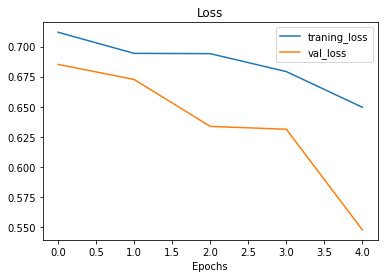

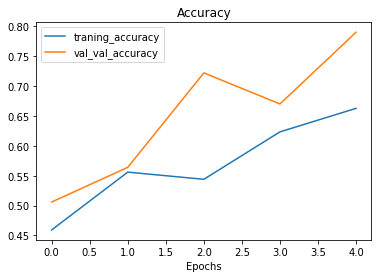

In [101]:
plot_loss_curves(history_6)

In [102]:
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

train_data_augmented_shuffed = train_datagenerator_augmented.flow_from_directory(
    train_dir,
    batch_size = 32,   # 1번에 처리할 이미지의 갯수를 지정
    target_size = (224, 224), # 이미지의 크기를 224, 244로 조정 (resize)
    class_mode = "binary", # 우리가 처리할 방법
    shuffle = True
)

Found 1500 images belonging to 2 classes.


In [103]:
model_7 = Sequential([
    Conv2D(
        filters = 10,
        kernel_size = 3,
        strides = 1,
        padding = "valid",
        activation = "relu",
        input_shape = (224, 224, 3)
    ),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = "sigmoid")
])

model_7.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_7 = model_7.fit(
    train_data_augmented_shuffed,
    epochs = 5,
    validation_data = valid_data
)

Epoch 1/5
47/47 [==============================] - 23s 476ms/step - loss: 0.6493 - accuracy: 0.6060 - val_loss: 0.6015 - val_accuracy: 0.6440
Epoch 2/5
47/47 [==============================] - 23s 485ms/step - loss: 0.5872 - accuracy: 0.6773 - val_loss: 0.4488 - val_accuracy: 0.8240
Epoch 3/5
47/47 [==============================] - 23s 495ms/step - loss: 0.5115 - accuracy: 0.7547 - val_loss: 0.3911 - val_accuracy: 0.8260
Epoch 4/5
47/47 [==============================] - 23s 493ms/step - loss: 0.4872 - accuracy: 0.7700 - val_loss: 0.3490 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 23s 491ms/step - loss: 0.4638 - accuracy: 0.7767 - val_loss: 0.3254 - val_accuracy: 0.8600


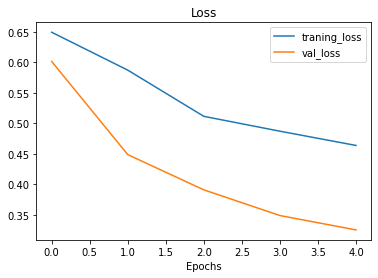

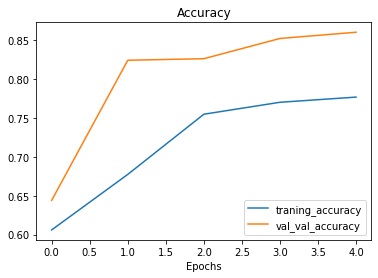

In [104]:
plot_loss_curves(history_7)

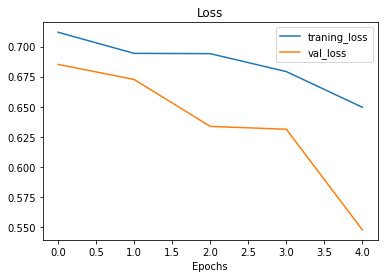

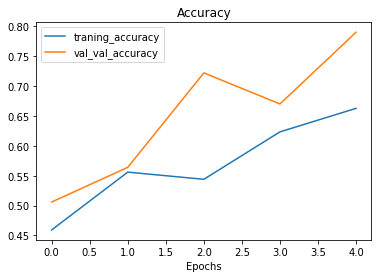

In [105]:
plot_loss_curves(history_6)

In [106]:
model_8 = Sequential([
    Conv2D(
        filters = 10,
        kernel_size = 3,
        strides = 1,
        padding = "valid",
        activation = "relu",
        input_shape = (224, 224, 3)
    ),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = "sigmoid")
])

model_8.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_8 = model_8.fit(
    train_data_augmented_shuffed,
    epochs = 5,
    validation_data = valid_data
)

Epoch 1/5
47/47 [==============================] - 33s 696ms/step - loss: 0.6113 - accuracy: 0.6413 - val_loss: 0.6678 - val_accuracy: 0.6020
Epoch 2/5
47/47 [==============================] - 36s 754ms/step - loss: 0.5754 - accuracy: 0.7127 - val_loss: 0.4827 - val_accuracy: 0.8140
Epoch 3/5
47/47 [==============================] - 35s 745ms/step - loss: 0.5434 - accuracy: 0.7340 - val_loss: 0.4357 - val_accuracy: 0.8080
Epoch 4/5
47/47 [==============================] - 35s 750ms/step - loss: 0.5374 - accuracy: 0.7533 - val_loss: 0.4053 - val_accuracy: 0.8440
Epoch 5/5
47/47 [==============================] - 36s 766ms/step - loss: 0.5228 - accuracy: 0.7533 - val_loss: 0.4238 - val_accuracy: 0.8220


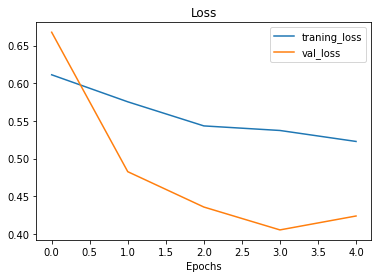

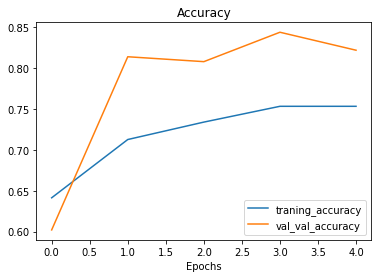

In [107]:
plot_loss_curves(history_8)

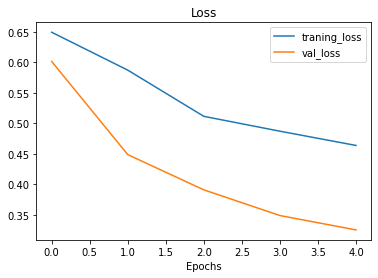

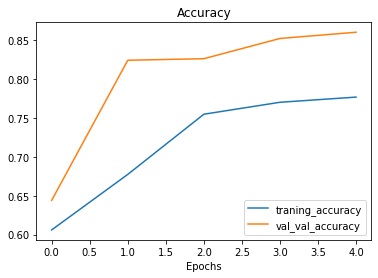

In [108]:
plot_loss_curves(history_7)

In [109]:
model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 28090)            

In [110]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

In [112]:
print(class_name)

['pizza' 'steak']


In [113]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg

--2021-08-29 14:20:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: '03-steak.jpeg'

     0K .......... .......... .......... .......... ..........  2% 1.31M 1s
    50K .......... .......... .......... .......... ..........  5% 2.55M 1s
   100K .......... .......... .......... .......... ..........  7% 1.73M 1s
   150K .......... .......... .......... .......... .......... 10% 5.50M 1s
   200K .......... .......... .......... .......... .......... 12% 1.61M 1s
   250K .......... .......... .......... .......... .......... 15% 4.63M 1s
   300K .......... .......... .......... .......... .......... 18% 5.88M 1s
   350K ....

(-0.5, 3023.5, 4031.5, -0.5)

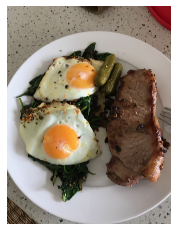

In [124]:
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False)

In [125]:
steak.shape

(4032, 3024, 3)

In [126]:
def load_and_pred_image(filename, img_shape=224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.resize(img, size = [img_shape, img_shape])
    img = img / 255.
    
    return img


In [127]:
steak = load_and_pred_image("03-steak.jpeg")
steak, steak.shape

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],
 
        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],
 
        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],
 
        ...,
 
        [[0.49313724, 0.42745098

In [128]:
model_8.predict(steak)

ValueError: in user code:

    c:\lecture_tensorflow\venv\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    c:\lecture_tensorflow\venv\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\lecture_tensorflow\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\lecture_tensorflow\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\lecture_tensorflow\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\lecture_tensorflow\venv\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    c:\lecture_tensorflow\venv\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    c:\lecture_tensorflow\venv\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\lecture_tensorflow\venv\lib\site-packages\keras\engine\input_spec.py:229 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (32, 224, 3)


In [129]:
## 학습할 때 데이터의 형태 (batch_size, 224, 224, 3)
## prediction의 경우 (224, 224, 3) -> (1, 224, 224, 3)의 형태가 되어야 한다!
print(f"{steak.shape}")
steak = tf.expand_dims(steak, axis = 0)
print(f"{steak.shape}")
steak

(224, 224, 3)
(1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],

        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],

        ...,

        [[0.49313724, 0.42745098, 

In [130]:
pred = model_8.predict(steak)
pred

array([[0.82531464]], dtype=float32)

In [131]:
pred_class = class_name[int(tf.round(pred)[0][0])]
pred_class

'steak'

In [135]:
def pred_and_plot(model, filename, class_names):
    img = load_and_pred_image(filename)
    pred = model.predict(tf.expand_dims(img, axis = 0))
    pred_class = class_name[int(tf.round(pred)[0][0])]

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

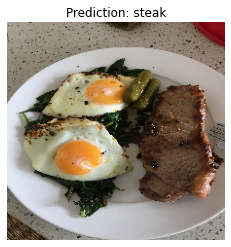

In [136]:
pred_and_plot(model_8, "03-steak.jpeg", class_name)

In [137]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 

--2021-08-29 14:37:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: '03-pizza-dad.jpeg'

     0K .......... .......... .......... .......... ..........  1% 1.03M 3s
    50K .......... .......... .......... .......... ..........  3% 2.70M 2s
   100K .......... .......... .......... .......... ..........  5% 1.51M 2s
   150K .......... .......... .......... .......... ..........  7% 4.37M 1s
   200K .......... .......... .......... .......... ..........  8% 1.86M 1s
   250K .......... .......... .......... .......... .......... 10% 4.34M 1s
   300K .......... .......... .......... .......... .......... 12% 5.46M 1s
   3

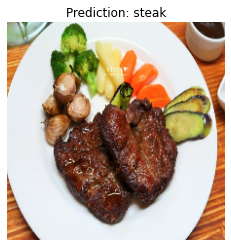

In [140]:
pred_and_plot(model_8, "test_002.jpg", class_name)

In [141]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

--2021-08-29 14:59:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.16, 34.64.4.112, 34.64.4.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: '10_food_classes_all_data.zip'

     0K .......... .......... .......... .......... ..........  0% 3.25M 2m32s
    50K .......... .......... .......... .......... ..........  0% 5.39M 2m2s
   100K .......... .......... .......... .......... ..........  0% 15.5M 92s
   150K .......... .......... .......... .......... ..........  0% 14.9M 77s
   200K .......... .......... .......... .......... ..........  0% 12.3M 70s
   250K .......... .......... .......... .......... ..........  0% 16.0M 63s
   300K .......... .......... .......... .......... ..........  0% 15.5M 59s
   350K .......... .

In [142]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()


In [143]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
    print(f"{dirpath}에는 {len(dirnames)}개의 디렉토리와 {len(filenames)}개의 파일이 존재합니다.")

10_food_classes_all_data에는 2개의 디렉토리와 0개의 파일이 존재합니다.
10_food_classes_all_data\test에는 10개의 디렉토리와 0개의 파일이 존재합니다.
10_food_classes_all_data\test\chicken_curry에는 0개의 디렉토리와 250개의 파일이 존재합니다.
10_food_classes_all_data\test\chicken_wings에는 0개의 디렉토리와 250개의 파일이 존재합니다.
10_food_classes_all_data\test\fried_rice에는 0개의 디렉토리와 250개의 파일이 존재합니다.
10_food_classes_all_data\test\grilled_salmon에는 0개의 디렉토리와 250개의 파일이 존재합니다.
10_food_classes_all_data\test\hamburger에는 0개의 디렉토리와 250개의 파일이 존재합니다.
10_food_classes_all_data\test\ice_cream에는 0개의 디렉토리와 250개의 파일이 존재합니다.
10_food_classes_all_data\test\pizza에는 0개의 디렉토리와 250개의 파일이 존재합니다.
10_food_classes_all_data\test\ramen에는 0개의 디렉토리와 250개의 파일이 존재합니다.
10_food_classes_all_data\test\steak에는 0개의 디렉토리와 250개의 파일이 존재합니다.
10_food_classes_all_data\test\sushi에는 0개의 디렉토리와 250개의 파일이 존재합니다.
10_food_classes_all_data\train에는 10개의 디렉토리와 0개의 파일이 존재합니다.
10_food_classes_all_data\train\chicken_curry에는 0개의 디렉토리와 750개의 파일이 존재합니다.
10_food_classes_all_data\train\chicken_wings에는 0개의 디렉토리와 750개의 파일이 존재

In [144]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [146]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names, len(class_names))

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi'] 10


Image shape: (512, 512, 3)


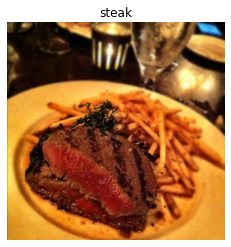

In [155]:
import random
img = view_random_image(
    target_dir = train_dir,
    target_class = random.choice(class_names)
)

In [156]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagenerator = ImageDataGenerator(rescale = 1./255)
test_datagenerator = ImageDataGenerator(rescale = 1./255)

train_data = train_datagenerator.flow_from_directory(
    train_dir,
    batch_size = 32,   # 1번에 처리할 이미지의 갯수를 지정
    target_size = (224, 224), # 이미지의 크기를 224, 244로 조정 (resize)
    class_mode = "categorical", # 우리가 처리할 방법    seed = 42
)

test_data = test_datagenerator.flow_from_directory(
    test_dir,
    batch_size = 32,   # 1번에 처리할 이미지의 갯수를 지정
    target_size = (224, 224), # 이미지의 크기를 224, 244로 조정 (resize)
    class_mode = "categorical", # 우리가 처리할 방법
)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [158]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model_9 = Sequential([
    Conv2D(
        filters = 10,
        kernel_size = 3,
        strides = 1,
        padding = "valid",
        activation = "relu",
        input_shape = (224, 224, 3)
    ),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation = "softmax")
])

model_9.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_9 = model_9.fit(
    train_data,
    epochs = 5,
    validation_data = test_data
)

Epoch 1/5
181/235 [======================>.......] - ETA: 33s - loss: 2.1611 - accuracy: 0.2117